<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/Gastric_Fed(VGG16)_98_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gastric:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5769059%2F9483807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T183404Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D680bc16b249993f515c395757d97a4a1326a89a80844199796e8e87b54712140dc150299ada5d1199e0719d7804bf12e878fbe56f9ce503cb3e300c25c0a1cdb81dc7b344a9994f2fea0a2329968276463aa991c0b6e18450411695fc907d1ae74b08d93ab98936fdd1b04afceecb77dd3488c559a4952ddc7765d2f79e3c1cf666c717af555db70c7debdebe28b226dac2b2b3197d415d3e8a9eaad3bc52fa711bee832c0115791ba8f09e41b8f15939421899e7e94de8f8f54ddc75974605b5bece929cf64b4fb08721ddb73bc7388583ef8a7081d835f271ef8a4f5699ef8990e7bc288f7e581182da2a8f7e60b5a7aee16fc6296e68a3a3a7c05be708278'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
import os
from sklearn.utils import shuffle

train_dir = '/kaggle/input/gastric/train/'
test_dir = '/kaggle/input/gastric/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Use os.path.join for proper path handling
    if os.path.isdir(label_dir):  # Ensure it's a directory
        for image in os.listdir(label_dir):
            train_paths.append(os.path.join(label_dir, image))  # Properly join the path
            train_labels.append(label)

# Shuffle paths and labels
train_paths, train_labels = shuffle(train_paths, train_labels)


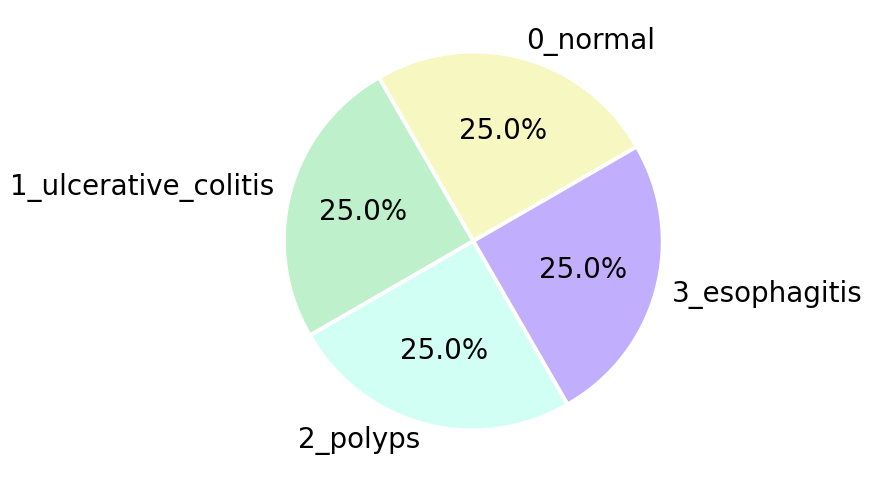

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='0_normal']),
         len([x for x in train_labels if x=='1_ulcerative_colitis']),
         len([x for x in train_labels if x=='2_polyps']),
         len([x for x in train_labels if x=='3_esophagitis'])],
        labels=['0_normal','1_ulcerative_colitis', '2_polyps', '3_esophagitis'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

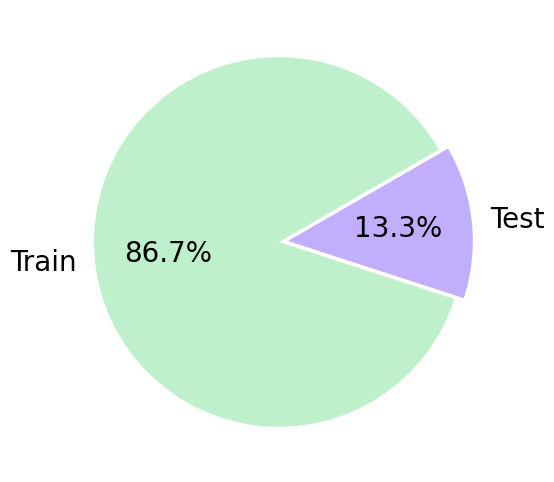

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

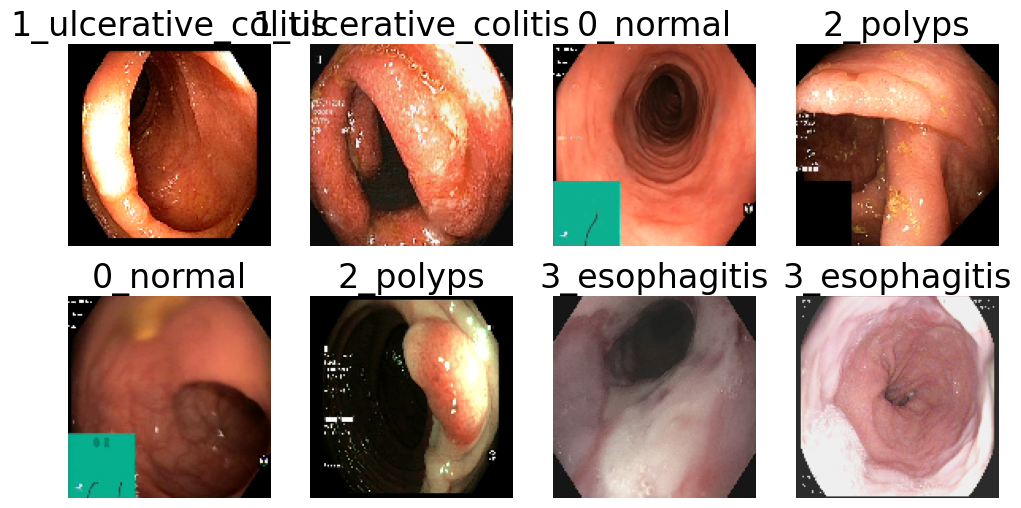

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

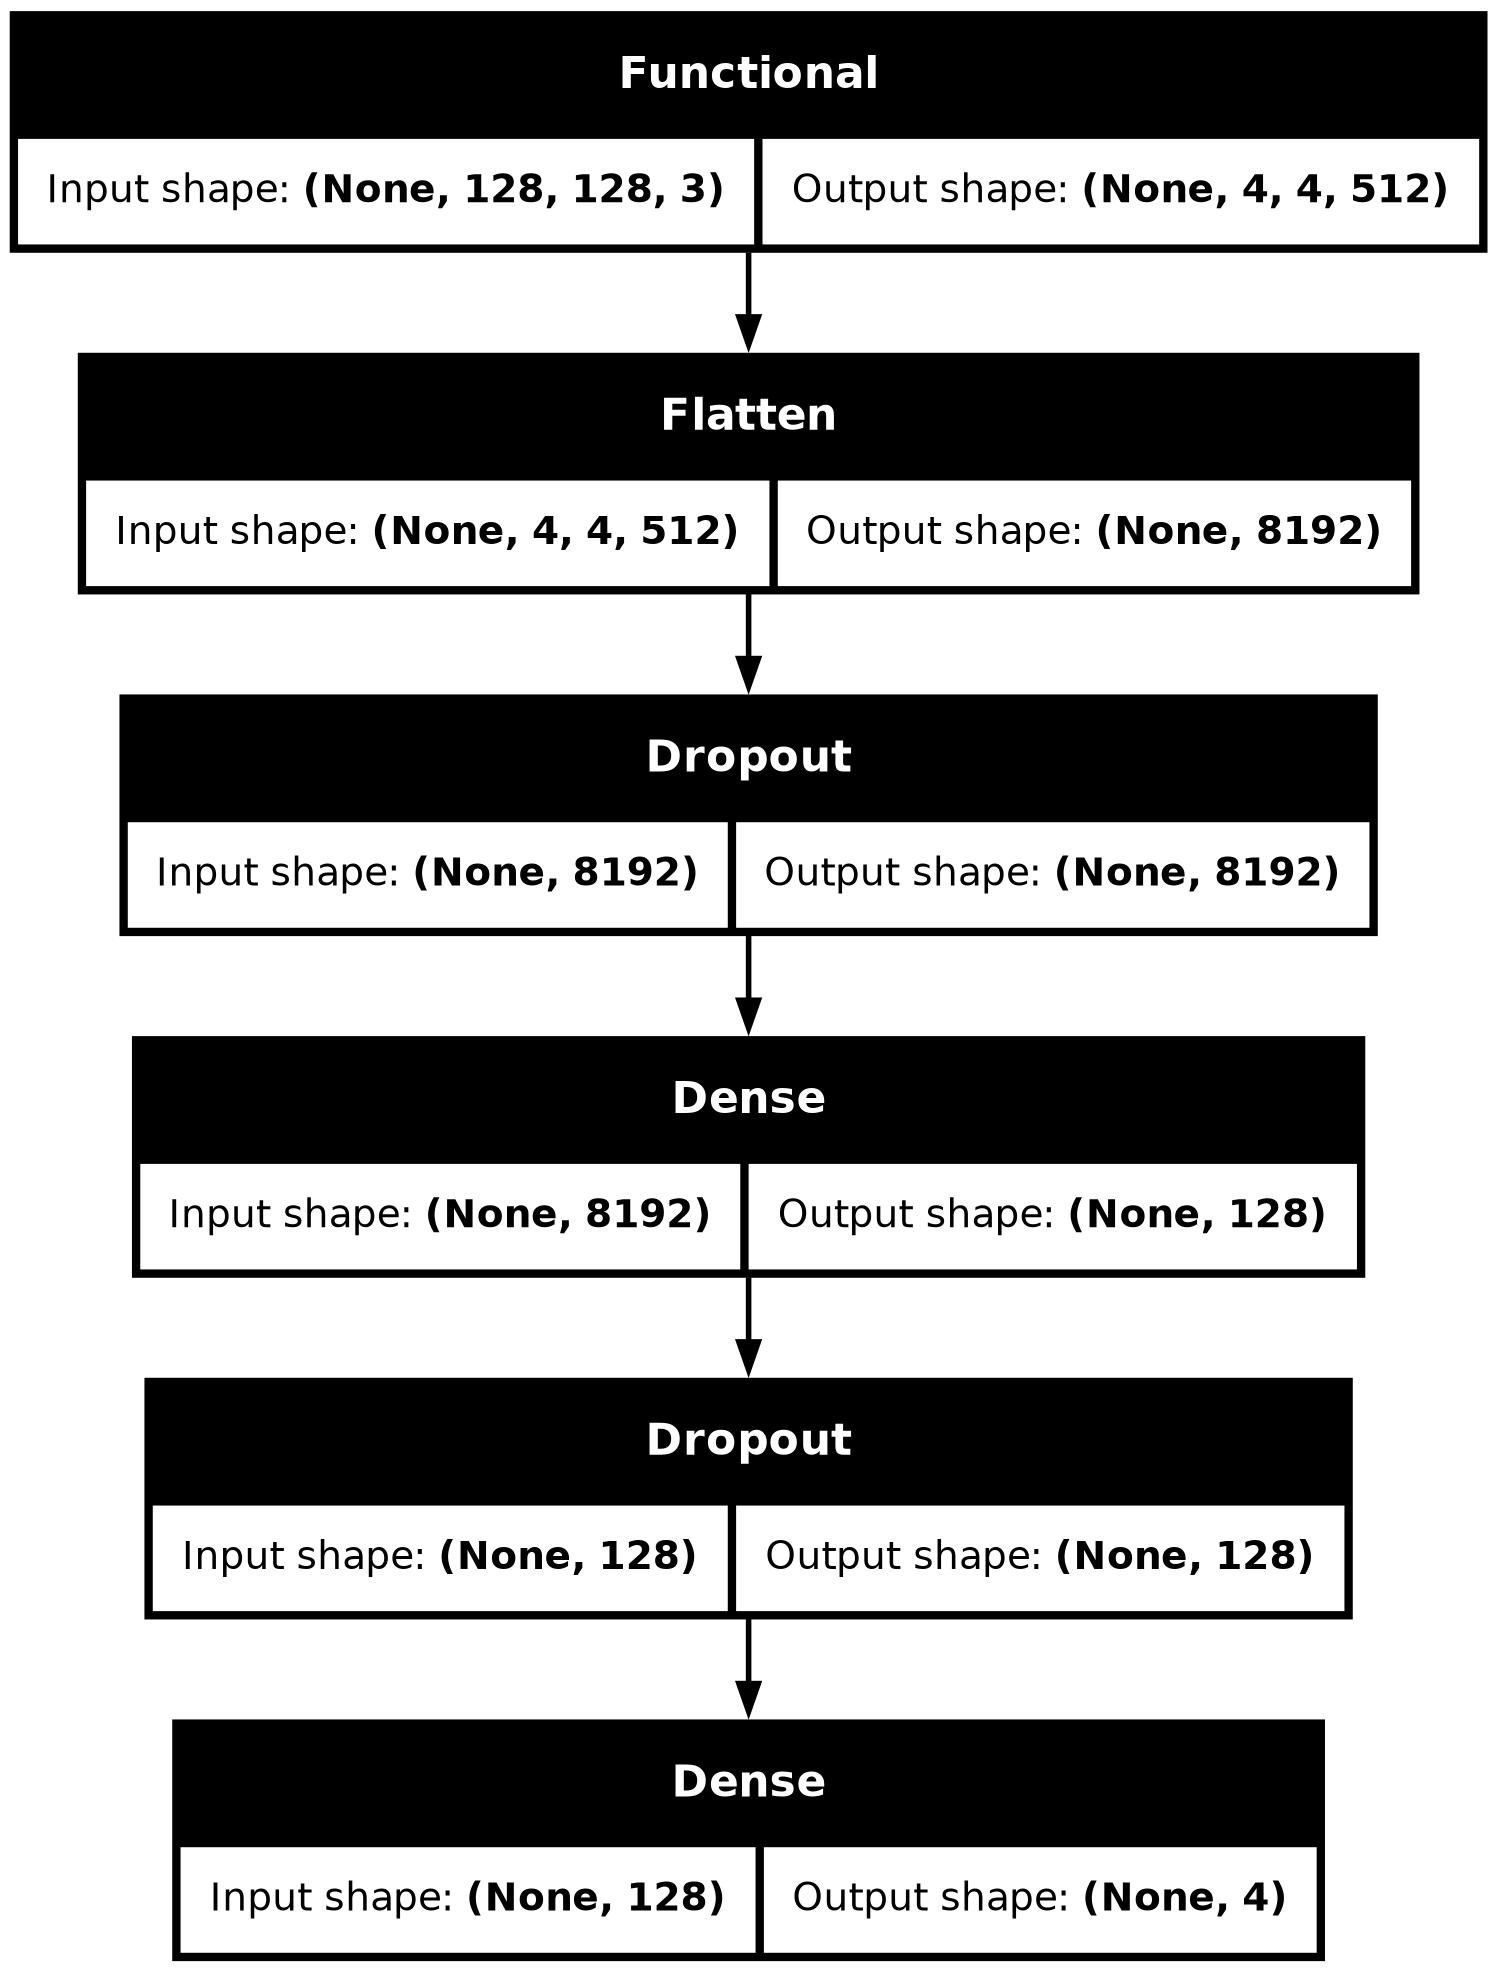

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 15
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15


I0000 00:00:1727366845.661426     132 service.cc:145] XLA service 0x7c5140012b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727366845.661511     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/208 ━━━━━━━━━━━━━━━━━━━━ 34:56 10s/step - loss: 1.3901 - sparse_categorical_accuracy: 0.3200

I0000 00:00:1727366853.871805     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 ━━━━━━━━━━━━━━━━━━━━ 92s 397ms/step - loss: 0.4306 - sparse_categorical_accuracy: 0.8174
Epoch 2/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - loss: 0.0705 - sparse_categorical_accuracy: 0.9720
Epoch 3/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - loss: 0.0460 - sparse_categorical_accuracy: 0.9838
Epoch 4/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - loss: 0.0357 - sparse_categorical_accuracy: 0.9867
Epoch 5/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - loss: 0.0193 - sparse_categorical_accuracy: 0.9925
Epoch 6/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9885
Epoch 7/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - loss: 0.0124 - sparse_categorical_accuracy: 0.9964
Epoch 8/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9921
Epoch 9/15
208/208 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9977
Epoch 10/15
208/208 ━━━━━━━━━━━━━━━━━━━

In [ ]:
#Federated Learning Based transfer Learning enabled VGG-16 Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 10
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9970
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 8.9736e-04 - sparse_categorical_accuracy: 0.9999
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 0.0063 - sparse_categorical_accuracy: 0.9989
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9879
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9927
Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9958
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9976
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - loss: 1.2277e-04 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 6.9624e-05 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step

  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  4%|▍         | 1/25 [00:04<01:40,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 2/25 [00:04<00:48,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 3/25 [00:05<00:32,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 4/25 [00:06<00:24,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 5/25 [00:06<00:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 6/25 [00:07<00:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 7/25 [00:08<00:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 8/25 [00:08<00:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 9/25 [00:09<00:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 10/25 [00:10<00:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 11/25 [00:10<00:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 12/25 [00:11<00:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 13/25 [00:11<00:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 14/25 [00:12<00:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 15/25 [00:13<00:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 16/25 [00:13<00:05,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 17/25 [00:14<00:05,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 18/25 [00:15<00:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 19/25 [00:15<00:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████  | 20/25 [00:16<00:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 21/25 [00:17<00:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 22/25 [00:17<00:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 23/25 [00:18<00:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 24/25 [00:19<00:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


In [ ]:
print(classification_report(y_true, y_pred))

                      precision    recall  f1-score   support

            0_normal       1.00      1.00      1.00       200
1_ulcerative_colitis       0.97      0.95      0.96       200
            2_polyps       0.96      0.97      0.97       200
       3_esophagitis       1.00      1.00      1.00       200

            accuracy                           0.98       800
           macro avg       0.98      0.98      0.98       800
        weighted avg       0.98      0.98      0.98       800



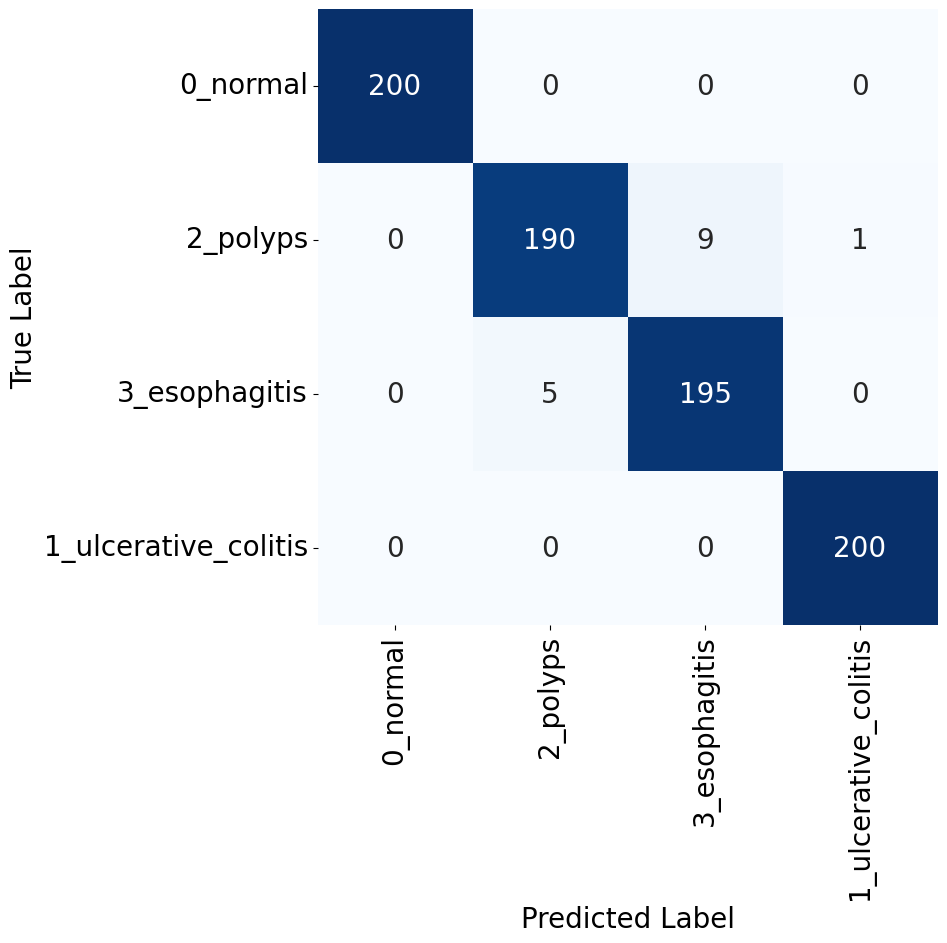

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

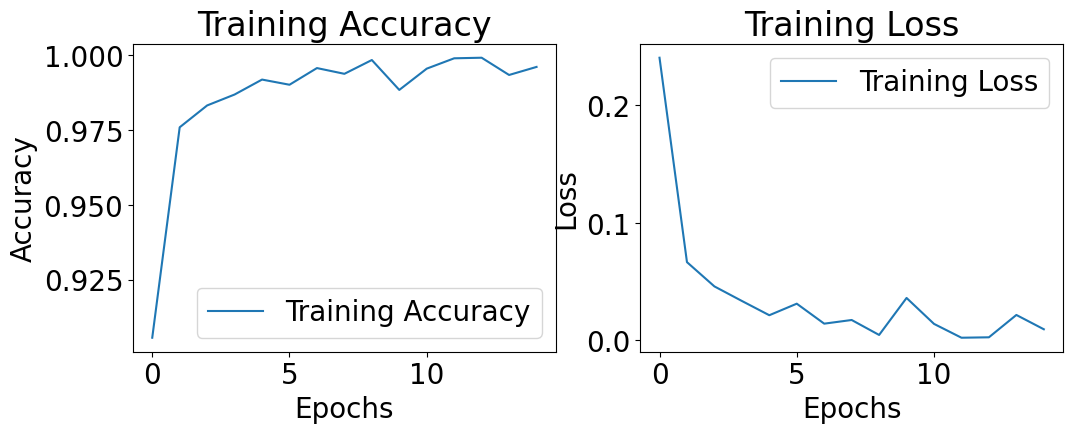

In [ ]:
def plot_training_history(history):
    acc = history.history['sparse_categorical_accuracy']
    loss = history.history['loss']

    # Plot Accuracy
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.show()

# Usage: Pass the training history object
plot_training_history(history)


In [ ]:
!pip install shap

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
from lime import lime_image
import shap


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

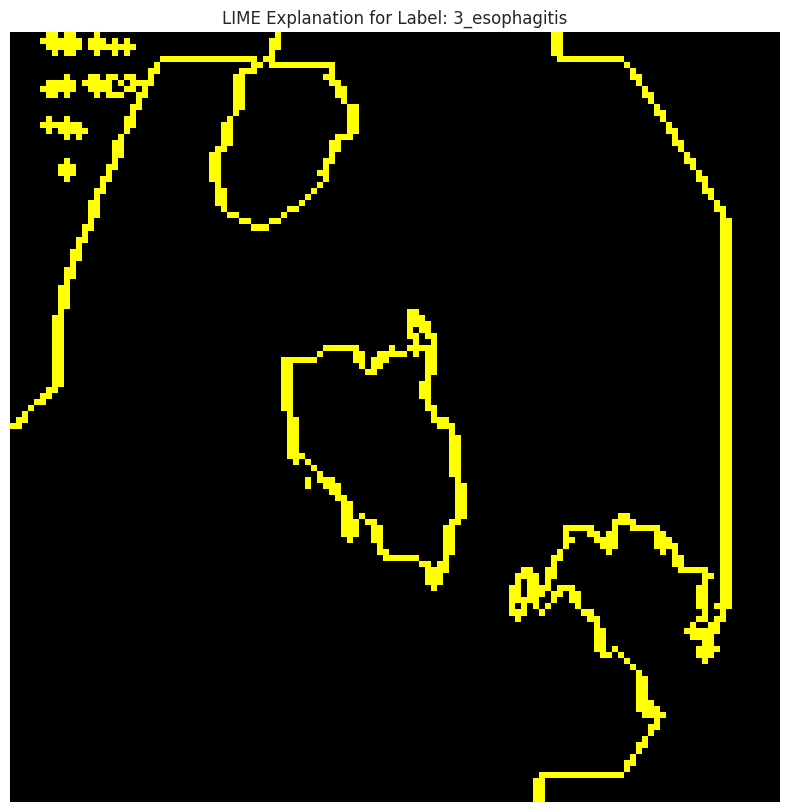

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_with_lime(model, image, label):
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain the prediction
    explanation = explainer.explain_instance(
        image,
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the top label from the explanation
    top_label = explanation.top_labels[0]

    # Get the image and mask using a different method
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the explanation
    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for Label: {label}")
    plt.axis('off')
    plt.show()

# Example of using LIME on a test image
sample_image_path = test_paths[0]  # Choose a sample image path from your test set
sample_image = load_img(sample_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
sample_image_array = np.array(sample_image) / 255.0

# Get the predicted label for the sample image
predicted_label = np.argmax(model.predict(sample_image_array[np.newaxis, ...]), axis=-1)
explain_with_lime(model, sample_image_array, decode_label(predicted_label)[0])


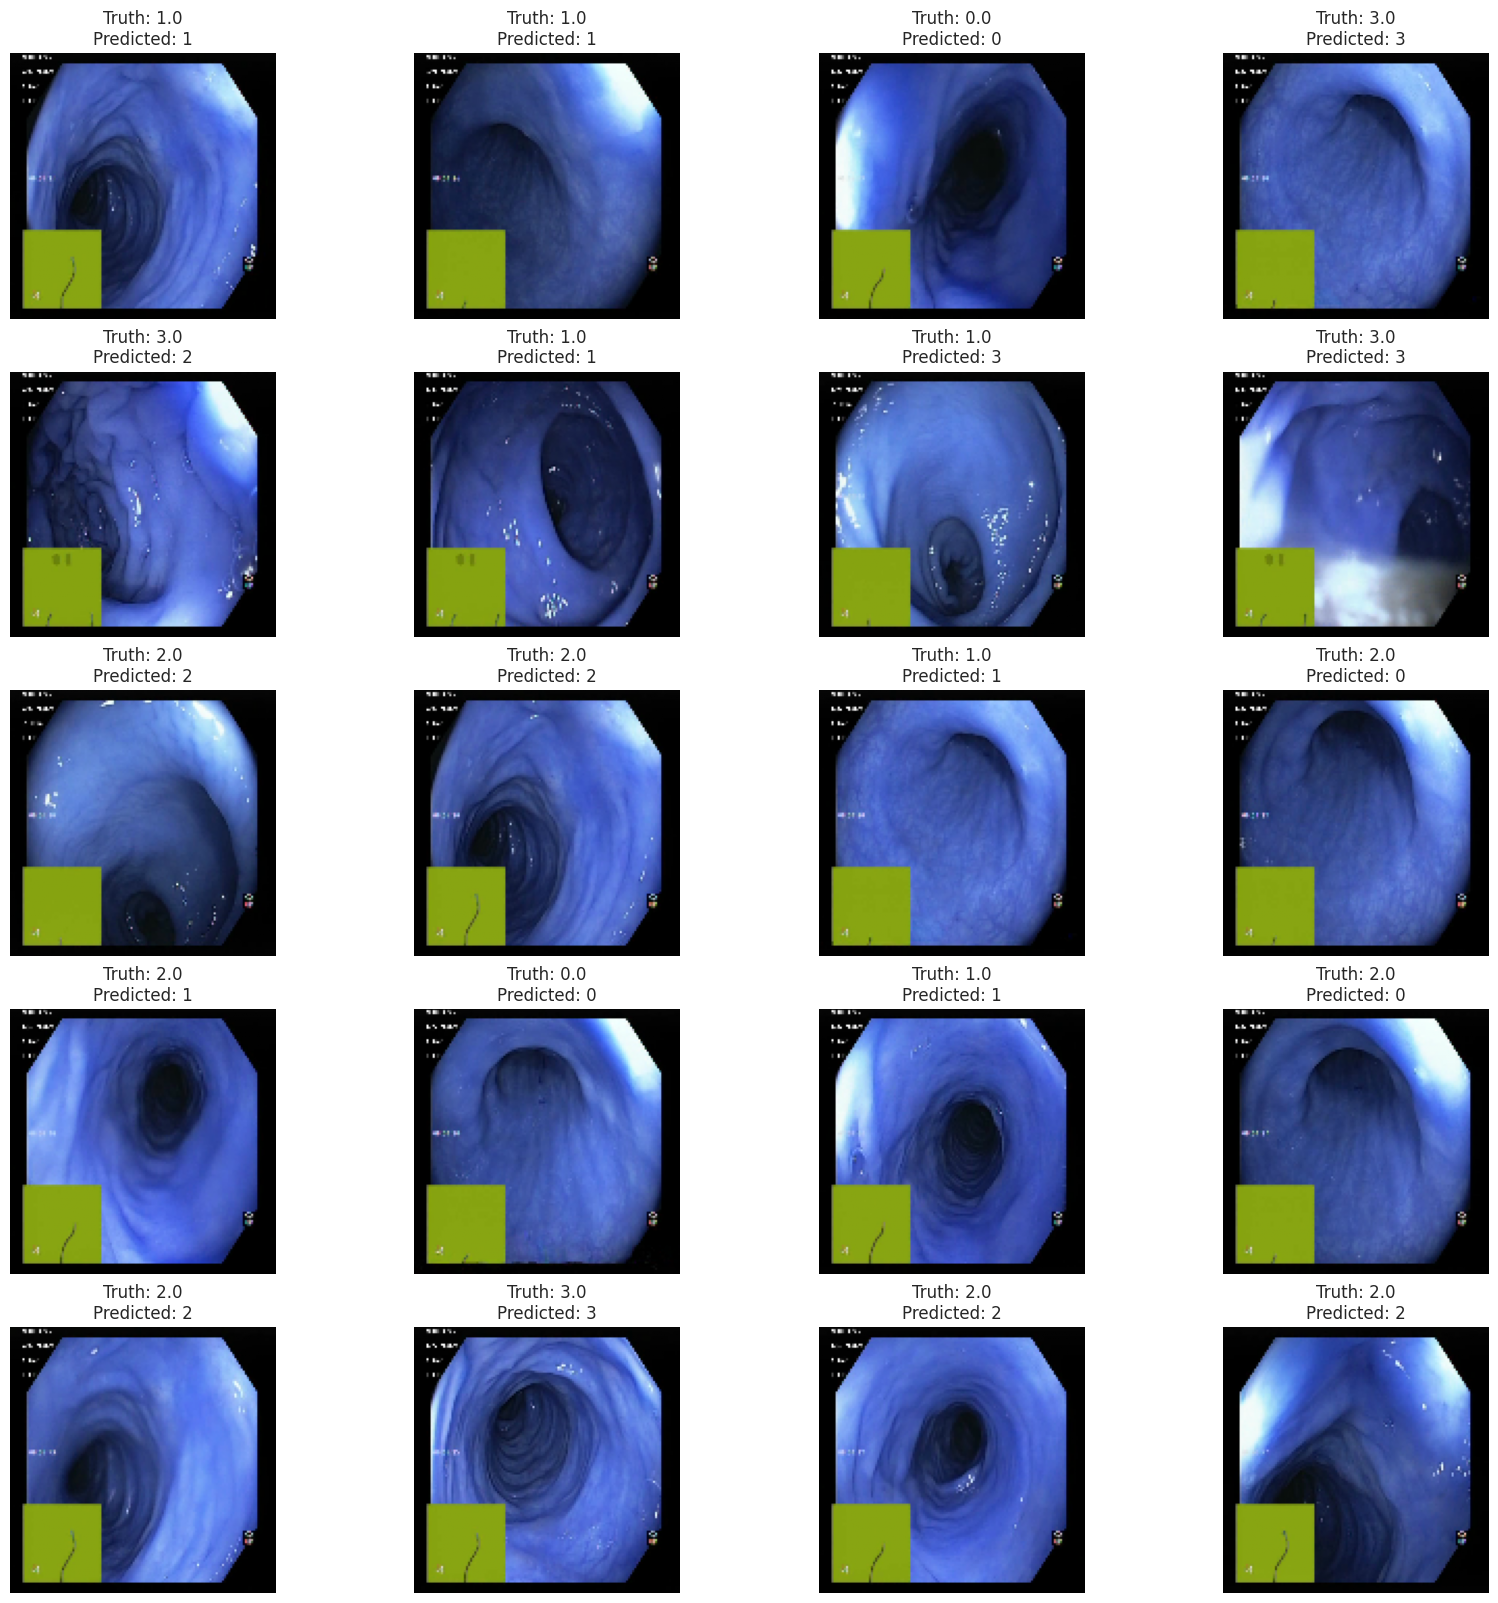

In [ ]:
# Assuming y_true holds the true labels for your test dataset
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {y_true[i]}\nPredicted: {y_pred[i]}")
    plt.axis('off')
plt.show()
